# Linear Regression with mini-batch

* y와 한 개 이상의 독립 변수 (또는 설명 변수) X와의 선형 상관 관계를 모델링하는 회귀분석 기법이다. 한 개의 설명 변수에 기반한 경우에는 단순 선형 회귀, 둘 이상의 설명 변수에 기반한 경우에는 다중 선형 회귀라고 한다. [참고: 위키피디아](https://ko.wikipedia.org/wiki/선형_회귀)

$$y_{\textrm{pred}} = \boldsymbol{W}^{\top}\boldsymbol{x} + b$$

* $\boldsymbol{x} = [x_{1}, x_{2}, \cdots, x_{d}]$
* $\boldsymbol{W} = [w_{1}, w_{2}, \cdots, w_{d}]$
* Loss function: $\mathcal{L} = \sum^{N} (y_{\textrm{pred}} - y)^{2}$

## Training Pseudo Code

```python
for epoch in max_epochs: # 1 epoch: 모든 데이터(N)를 한번 학습 시켰을 때
  for step in num_batches: # num_batches = int(data_size / batch_size)
    1. sampling mini-batches with batch_size
      1-1. data augmentation (필요하면)
    2. calculate the logits # logits = f(x)
    3. calculate the loss # loss = loss(logits, labels)
    4. calculate the gradient with respect to weights
    5. update weights
```

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/lab4all/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Phase 1. Build a model

### Make data

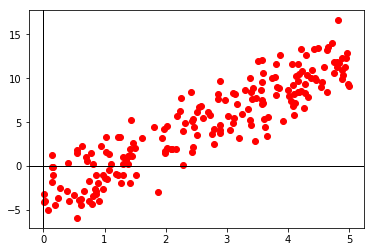

In [2]:
np.random.seed(219)

_a = 3
_b = -3
N = 200
data_x = np.random.uniform(low=0, high=5, size=N)
data_y = _a * data_x + _b + np.random.normal(0, 2, N)

plt.plot(data_x, data_y, 'ro')
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.show()

### Create placeholders for inputs and labels

In [3]:
# x: inputs
x = tf.placeholder(tf.float32, shape=[None], name='x')
# y: labels
y = tf.placeholder(tf.float32, shape=[None], name='y')

### Create weight and bias

In [4]:
tf.set_random_seed(219)

# create Variables
W = tf.get_variable(name="weights", shape=[], initializer=tf.random_normal_initializer())
b = tf.get_variable(name="bias", shape=[], initializer=tf.random_uniform_initializer())

### Build a model: $y = Wx + b$

In [5]:
y_pred = W * x + b

### Define loss function

In [6]:
#loss = tf.reduce_mean(tf.square(y_pred - y), name="loss")
loss = tf.losses.mean_squared_error(labels=y, predictions=y_pred, scope='loss')

### Create a optimizer

In [7]:
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)

## Phase 2. Train a model

### Train a model

In [8]:
batch_size = 8

with tf.Session(config=sess_config) as sess:
  # Initialize all variables
  sess.run(tf.global_variables_initializer())
  
  writer = tf.summary.FileWriter('graphs/01.2.linear.regression.with.minibatch', sess.graph)
  writer.close()
  
  # train the model
  max_epochs = 100
  loss_history = []
  num_batches_per_epoch = int(N / batch_size)
  start_time = time.time()
  for epoch in range(max_epochs):
    total_loss = 0.0
    shuffle_index = np.random.permutation(len(data_x))
    for step in range(num_batches_per_epoch):
      x_ = data_x[shuffle_index[step*batch_size:(step+1)*batch_size]]
      y_ = data_y[shuffle_index[step*batch_size:(step+1)*batch_size]]
      _, loss_ = sess.run([train_op, loss],
                          feed_dict={x: x_,
                                     y: y_})
      total_loss += loss_ * batch_size
    total_loss /= float(N)
    loss_history.append(total_loss)
    
    if (epoch+1) % 10 == 0:
      print('Epoch %d: total_loss: %f' % (epoch+1, total_loss))
      
  print('training done!')
  print('elapsed time {} sec'.format(time.time() - start_time))

  W_, b_ = sess.run([W, b])

Epoch 10: total_loss: 5.136449
Epoch 20: total_loss: 4.571304
Epoch 30: total_loss: 4.535003
Epoch 40: total_loss: 4.532011
Epoch 50: total_loss: 4.583322
Epoch 60: total_loss: 4.511683
Epoch 70: total_loss: 4.509807
Epoch 80: total_loss: 4.511325
Epoch 90: total_loss: 4.577898
Epoch 100: total_loss: 4.525902
training done!
elapsed time 1.768334150314331 sec


### Print the results: W and b

* 정답 W = 3, b = -3

In [9]:
print(W_, b_)

3.1080909 -3.3650653


### Plot the loss funtion

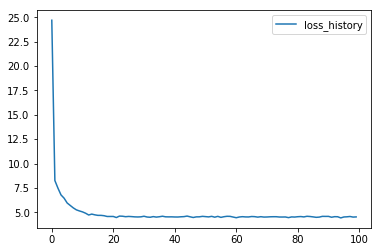

In [10]:
plt.plot(loss_history, label='loss_history')
plt.legend()
plt.show()

### Plot the results

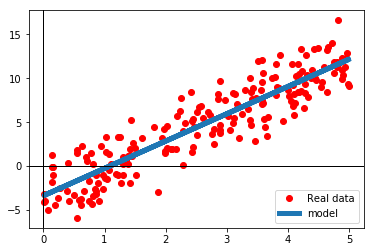

In [11]:
plt.plot(data_x, data_y, 'ro', label='Real data')
plt.plot(data_x, W_ * data_x + b_, lw=5, label='model')
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.legend()
plt.show()